# <a id='toc1_'></a>[YouTube History Analysis](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [YouTube History Analysis](#toc1_)    
- [Imports and variables](#toc2_)    
- [General watching stats](#toc3_)    
  - [Amounts](#toc3_1_)    
  - [Moments](#toc3_2_)    
- [Topic category frequency](#toc4_)    
  - [Most frequent in period](#toc4_1_)    
  - [Most frequent by period](#toc4_2_)    
  - [Frequency over time](#toc4_3_)    
- [Tag frequency](#toc5_)    
  - [Most frequent in period](#toc5_1_)    
  - [Most frequent by period](#toc5_2_)    
  - [Frequency over time](#toc5_3_)    
- [Clustering utilities](#toc6_)    
  - [Visualization](#toc6_1_)    
  - [K-Means](#toc6_2_)    
  - [Agglomerative clustering](#toc6_3_)    
- [Topic category clustering](#toc7_)    
  - [Category embedding](#toc7_1_)    
  - [K-Means](#toc7_2_)    
  - [Agglomerative clustering](#toc7_3_)    
- [Tag clustering](#toc8_)    
  - [Tag embedding](#toc8_1_)    
  - [K-Means](#toc8_2_)    
  - [Agglomerative clustering](#toc8_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=2
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Imports and variables](#toc0_)

In [468]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from statistics import mean
import spacy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from file_manager import FileManager

In [469]:
plt.style.use('ggplot')

In [470]:
processed_history = FileManager.load_processed_history()

In [471]:
last_time_str = processed_history[0]['time']

# The last time you watched a video
last_time = datetime.fromisoformat(last_time_str.replace("Z", "+00:00"))

# The beginning of the day of last_time
last_time_zero = last_time.replace(hour=0, minute=0, second=0, microsecond=0)

# The end of the day of last_time
last_time_midnight = last_time.replace(hour=23, minute=59, second=59)

In [472]:
# Number of categories and tags to consider for frequency analysis
max_most_common = 25

# <a id='toc3_'></a>[General watching stats](#toc0_)

## <a id='toc3_1_'></a>[Amounts](#toc0_)

Understand how many videos you have watched recently. All videos that appear in your history count as watched, even if you immediately closed them.
Shorts are included.

### Utilities

In [473]:
# Get the number of watched videos between two dates

def get_count_in_period(start = None, end = None):
    count = 0
    for video in processed_history:
        time = datetime.fromisoformat(video['time'].replace("Z", "+00:00"))
        if (start is None or time >= start) and (end is None or time <= end):
            count += 1
    return count

In [483]:
# Get the number of watched videos for intervals between two dates

def get_count_by_interval(start, end, min_start, interval, date_format='%d/%m'):
    intervals, counts = [], []

    while start >= min_start:
        _counts = get_count_in_period(start, end)
        counts.append(_counts)
        intervals.append(start.strftime(date_format))
        start = start - interval
        end = end - interval
    
    return intervals[::-1], counts[::-1]

In [484]:
# Plot counts for intervals

def plot_amount_by_interval(intervals, counts, title):
    plt.figure(figsize=(10, 5))
    plt.plot(intervals, counts, marker='o', label='Watched videos')
    mean_amount = mean(counts)
    median_amount = np.median(counts)
    plt.axhline(y = mean_amount, color='g', linestyle = '--', label='Mean: {:.2f}'.format(mean_amount))
    plt.axhline(y = median_amount, color='b', linestyle = '--', label='Median: {:.2f}'.format(median_amount))
    plt.title(f"Number of watched videos in {title}")
    plt.xlabel('Period')
    plt.ylabel('Number of watched videos')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.legend()
    plt.show()

### By day (last 30)

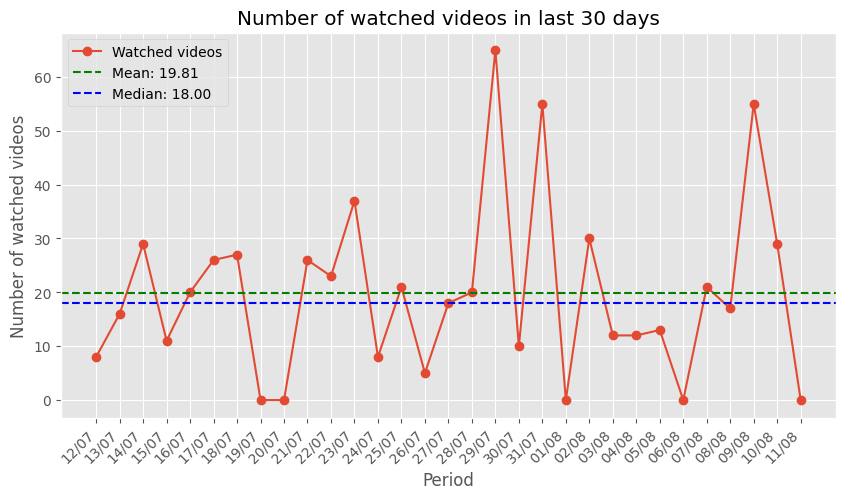

In [485]:
start = last_time.replace(hour=0, minute=0, second=0, microsecond=0)
end = last_time.replace(hour=23, minute=59, second=59, microsecond=59)
thirty_days_ago = start - timedelta(days=30)

intervals, counts = get_count_by_interval(start, end, thirty_days_ago, timedelta(days=1))

plot_amount_by_interval(intervals, counts, "last 30 days")

### By week (last 20)

In [ ]:
start = last_time.replace(hour=0, minute=0, second=0, microsecond=0) - timedelta(days=6)
end = last_time.replace(hour=23, minute=59, second=59, microsecond=59)
twenty_weeks_ago = start - timedelta(weeks=19)

intervals, counts = get_count_by_interval(start, end, twenty_weeks_ago, timedelta(weeks=1))

plot_amount_by_interval(intervals, counts, "last 20 weeks")

### By month (last 24)

In [ ]:
start = last_time.replace(hour=0, minute=0, second=0, microsecond=0) - relativedelta(months=1)
end = last_time.replace(hour=23, minute=59, second=59, microsecond=59)
two_years_ago = start - relativedelta(months=23)

intervals, counts = get_count_by_interval(start, end, two_years_ago, relativedelta(months=1), date_format='%m/%Y')

plot_amount_by_interval(intervals, counts, "last 2 years")

## <a id='toc3_2_'></a>[Moments](#toc0_)

Understand what are the days of the week and the hours of the day when you usually watch YouTube.

### Distribution over days of week

#### Utilities

In [413]:
# Plot the distribution of the number of watched videos by day of the week 
# for videos watched between two dates

def plot_amount_distribution_by_week_day(start = None, end = None):
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    counts = [0, 0, 0, 0, 0, 0, 0]
    
    for video in processed_history:
        time = datetime.fromisoformat(video['time'].replace("Z", "+00:00"))
        if (start is None or start <= time) and (end is None or time <= end):
            counts[time.weekday()] += 1
            
    plt.bar(days, counts)
    plt.title('Watched videos by day of the week')
    plt.xlabel('Day of the Week')
    plt.ylabel('Number of watched videos')
    plt.show()

#### Last week

In [ ]:
start = last_time_midnight - timedelta(days=7)
plot_amount_distribution_by_week_day(start)

#### Last month

In [ ]:
start = last_time_midnight - relativedelta(months=1)
plot_amount_distribution_by_week_day(start)

#### Last 6 months

In [ ]:
start = last_time_midnight - relativedelta(months=6)
plot_amount_distribution_by_week_day(start)

#### Last year

In [ ]:
start = last_time_midnight - relativedelta(years=1)
plot_amount_distribution_by_week_day(start)

#### All time

In [ ]:
plot_amount_distribution_by_week_day()

### Distribution over hours of day

#### Utilities

In [419]:
# Plot the distribution of the number of watched videos by day of the week 
# for videos watched between two dates

def plot_amount_distribution_by_hour(start = None, end = None):
    hours = [str(i) for i in range(24)]
    counts = [0] * 24

    for video in processed_history:
        time = datetime.fromisoformat(video['time'].replace("Z", "+00:00"))
        if (start is None or start <= time) and (end is None or time <= end):
            counts[time.hour] += 1
    
    plt.bar(hours, counts)
    plt.title('Watched videos by hour of the day')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of watched videos')
    plt.show()

#### Last week

In [ ]:
start = last_time_midnight - timedelta(days=7)
plot_amount_distribution_by_hour(start)

#### Last month

In [ ]:
start = last_time_midnight - relativedelta(months=1)
plot_amount_distribution_by_hour(start)

#### Last 6 months

In [ ]:
start = last_time_midnight - relativedelta(months=6)
plot_amount_distribution_by_hour(start)

#### Last year

In [ ]:
start = last_time_midnight - relativedelta(years=1)
plot_amount_distribution_by_hour(start)

#### All time

In [ ]:
plot_amount_distribution_by_hour()

# <a id='toc4_'></a>[Topic category frequency](#toc0_)

Understand what topics your watched videos are usually about and how they have changed over time.

## <a id='toc4_1_'></a>[Most frequent in period](#toc0_)

### Utilities

In [425]:
# Get the number of watched videos by category between two dates

def get_category_counts(start = None, end = None, max_most_common=max_most_common):
    category_names = []

    for video in processed_history:
        time = datetime.fromisoformat(video['time'].replace("Z", "+00:00"))

        if (start is None or time >= start) and (end is None or time <= end):
            for category in video['topicCategories']:
                category_name = category.split('/')[-1]
                category_names.append(category_name)
            
    category_counts = Counter(category_names)
    
    if not category_counts:
        return [], []
    else:
        return zip(*category_counts.most_common(max_most_common))

In [426]:
# Plot the distribution of the number of watched videos by category

def draw_bar_chart(categories, counts, period, max_most_common=max_most_common):
    plt.figure(figsize=(10, 6))
    plt.barh(categories, counts)
    plt.xlabel('Frequency')
    plt.ylabel('Category Names')
    plt.title(f"{max_most_common} most frequent categories {period}")
    plt.show()

### Last week

In [ ]:
start = last_time_midnight - timedelta(days=7)
tags, counts = get_category_counts(start)
draw_bar_chart(tags[::-1], counts[::-1], "7 days")

### Last month

In [ ]:
thirty_days_ago = last_time_midnight - relativedelta(months=1)
tags, counts = get_category_counts(thirty_days_ago)
draw_bar_chart(tags[::-1], counts[::-1], "last month")

### Last 6 months

In [ ]:
six_months_ago = last_time_midnight - relativedelta(months=6)
tags, counts = get_category_counts(six_months_ago)
draw_bar_chart(tags[::-1], counts[::-1], "last 6 months")

### Last year

In [ ]:
one_year_ago = last_time_midnight - relativedelta(years=1)
tags, counts = get_category_counts(one_year_ago)
draw_bar_chart(tags[::-1], counts[::-1], "last 1 year")

### All time

In [ ]:
tags, counts = get_category_counts(None)
draw_bar_chart(tags[::-1], counts[::-1], "all time")

## <a id='toc4_2_'></a>[Most frequent by period](#toc0_)

### Utilities

In [432]:
# Print the frequency of the most common categories for intervals between two dates

def print_category_frequency_per_period(start, end, min_start, interval, max_per_period = 5):
    # Get all counts
    periods, categories, counts = [], [], []
    while start >= min_start:
        _categories, _counts = get_category_counts(start, end)
        categories.append(_categories)
        counts.append(_counts)
        periods.append(f"{start.strftime('%d/%m/%Y')} - {end.strftime('%d/%m/%Y')}")
        start = start - interval
        end = end - interval

    # Print counts for most common categories
    for i in range(len(periods)):
        print(periods[i], end="\t\t")
        for j in range(min(max_per_period, len(categories[i]))):
            print(f"{categories[i][j]} ({counts[i][j]})", end=", ")
        print()

### By day (last 30)

In [ ]:
start = last_time.replace(hour=0, minute=0, second=0, microsecond=0)
end = last_time.replace(hour=23, minute=59, second=59, microsecond=59)
min_start = start - timedelta(days=30)
interval = timedelta(days=1)

print_category_frequency_per_period(start, end, min_start, interval)

### By week (last 20)

In [ ]:
start = last_time.replace(hour=0, minute=0, second=0, microsecond=0) - timedelta(days=6)
end = last_time.replace(hour=23, minute=59, second=59, microsecond=59)
min_start = start - timedelta(weeks=19)
interval = timedelta(days=7)

print_category_frequency_per_period(start, end, min_start, interval)

### By month (last 24)

In [ ]:
start = last_time.replace(hour=0, minute=0, second=0, microsecond=0) - relativedelta(months=1)
end = last_time.replace(hour=23, minute=59, second=59, microsecond=59)
min_start = start - relativedelta(months=23)
interval = relativedelta(months=1)

print_category_frequency_per_period(start, end, min_start, interval)

## <a id='toc4_3_'></a>[Frequency over time](#toc0_)

### Utilities

In [436]:
# Plot the frequency variation of selected categories for intervals between two dates

def plot_category_frequency_variation(categories, start, end, min_start, interval, date_format='%d/%m'):
    periods = []
    counts = [[] for _ in range(len(categories))]

    while start >= min_start:
        _categories, _counts = get_category_counts(start, end)
        
        for i in range(len(categories)):
            if categories[i] in _categories:
                index = _categories.index(categories[i])
                counts[i].append(_counts[index])
            else:
                counts[i].append(0)

        periods.append(f"{start.strftime(date_format)} - {end.strftime(date_format)}")
        start = start - interval
        end = end - interval

    plt.figure(figsize=(10, 5))

    for i in range(len(categories)):
        plt.plot(periods[::-1], counts[i][::-1], marker='o', label=categories[i])

    plt.title('Frequency variation of topics')
    plt.xlabel('Period')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.legend()
    plt.show()

In [437]:
# You can change the topics to the ones you want to analyze
# By default it will use the top 5 most frequent topics in the last week

start = last_time_midnight - timedelta(days=7)
tags, _ = get_category_counts(start)
selected_categories = list(tags[:5])

### By day (last 30)

In [ ]:
start = last_time.replace(hour=0, minute=0, second=0, microsecond=0)
end = last_time.replace(hour=23, minute=59, second=59, microsecond=59)
min_start = start - timedelta(days=30)
interval = timedelta(days=1)

plot_category_frequency_variation(selected_categories, start, end, min_start, interval)

### By week (last 20)

In [ ]:
start = last_time.replace(hour=0, minute=0, second=0, microsecond=0) - timedelta(days=6)
end = last_time.replace(hour=23, minute=59, second=59, microsecond=59)
min_start = start - timedelta(weeks=19)
interval = timedelta(days=7)

plot_category_frequency_variation(selected_categories, start, end, min_start, interval)

### By month (lat 24)

In [ ]:
start = last_time.replace(hour=0, minute=0, second=0, microsecond=0) - relativedelta(months=1)
end = last_time.replace(hour=23, minute=59, second=59, microsecond=59)
min_start = start - relativedelta(months=23)
interval = relativedelta(months=1)

plot_category_frequency_variation(selected_categories, start, end, min_start, interval, date_format='%m/%Y')

# <a id='toc5_'></a>[Tag frequency](#toc0_)

Understand what tags usually appear in your watched videos and how thay have changed over time.

## <a id='toc5_1_'></a>[Most frequent in period](#toc0_)

### Utilities

In [441]:
# Get the number of watched videos by tag between two dates

def get_tag_counts(start = None, end = None, max_most_common=max_most_common):
    tags = []

    for video in processed_history:
        time = datetime.fromisoformat(video['time'].replace("Z", "+00:00"))
        if (start is None or time >= start) and (end is None or time <= end):
            tags.extend(video['tags'])

    counts = Counter(tags)
    
    if not counts:
        return [], []
    else:
        return zip(*counts.most_common(max_most_common))

In [442]:
# Plot the distribution of the number of watched videos by tag

def draw_bar_chart(tags, counts, period, max_most_common=max_most_common):
    plt.figure(figsize=(10, 6))
    plt.barh(tags, counts)
    plt.xlabel('Frequency')
    plt.ylabel('Tag')
    plt.title(f"{max_most_common} most frequent tags {period}")
    plt.show()

### Last week

In [ ]:
start = last_time_midnight - timedelta(days=7)
tags, counts = get_tag_counts(start)
draw_bar_chart(tags[::-1], counts[::-1], "7 days")

### Last month

In [ ]:
thirty_days_ago = last_time_midnight - relativedelta(months=1)
tags, counts = get_tag_counts(thirty_days_ago)
draw_bar_chart(tags[::-1], counts[::-1], "last month")

### Last 6 months

In [ ]:
six_months_ago = last_time_midnight - relativedelta(months=6)
tags, counts = get_tag_counts(six_months_ago)
draw_bar_chart(tags[::-1], counts[::-1], "last 6 months")

### Last year

In [ ]:
one_year_ago = last_time_midnight - relativedelta(years=1)
tags, counts = get_tag_counts(one_year_ago)
draw_bar_chart(tags[::-1], counts[::-1], "last 1 year")

### All time

In [ ]:
tags, counts = get_tag_counts(None)
draw_bar_chart(tags[::-1], counts[::-1], "all time")

## <a id='toc5_2_'></a>[Most frequent by period](#toc0_)

### Utilities

In [448]:
# Print the frequency of the most common tags for intervals between two dates

def print_tag_frequency_per_period(start, end, min_start, interval, max_per_period = 5):
    # get all counts
    periods, tags, counts = [], [], []
    while start >= min_start:
        _tags, _counts = get_tag_counts(start, end)
        tags.append(_tags)
        counts.append(_counts)
        periods.append(f"{start.strftime('%d/%m/%Y')} - {end.strftime('%d/%m/%Y')}")
        start = start - interval
        end = end - interval

    # print counts for most common tags
    for i in range(len(periods)):
        print(periods[i], end="\t\t")
        for j in range(min(max_per_period, len(tags[i]))):
            print(f"{tags[i][j]} ({counts[i][j]})", end=", ")
        print()

### By day (last 30)

In [ ]:
start = last_time.replace(hour=0, minute=0, second=0, microsecond=0)
end = last_time.replace(hour=23, minute=59, second=59, microsecond=59)
min_start = start - timedelta(days=30)
interval = timedelta(days=1)

print_tag_frequency_per_period(start, end, min_start, interval)

### By week (last 20)

In [ ]:
start = last_time.replace(hour=0, minute=0, second=0, microsecond=0) - timedelta(days=6)
end = last_time.replace(hour=23, minute=59, second=59, microsecond=59)
min_start = start - timedelta(weeks=19)
interval = timedelta(days=7)

print_tag_frequency_per_period(start, end, min_start, interval)

### By month (last 24)

In [ ]:
start = last_time.replace(hour=0, minute=0, second=0, microsecond=0) - relativedelta(months=1)
end = last_time.replace(hour=23, minute=59, second=59, microsecond=59)
min_start = start - relativedelta(months=23)
interval = relativedelta(months=1)

print_tag_frequency_per_period(start, end, min_start, interval)

## <a id='toc5_3_'></a>[Frequency over time](#toc0_)

### Utilities

In [452]:
# Plot the frequency variation of selected tags for intervals between two dates

def plot_tag_frequency_variation(tags, start, end, min_start, interval, date_format='%d/%m'):
    periods = []
    counts = [[] for _ in range(len(tags))]

    while start >= min_start:
        _tags, _counts = get_tag_counts(start, end)
        
        for i in range(len(tags)):
            if tags[i] in _tags:
                index = _tags.index(tags[i])
                counts[i].append(_counts[index])
            else:
                counts[i].append(0)

        periods.append(f"{start.strftime(date_format)} - {end.strftime(date_format)}")
        start = start - interval
        end = end - interval

    plt.figure(figsize=(10, 5))

    for i in range(len(tags)):
        plt.plot(periods[::-1], counts[i][::-1], marker='o', label=tags[i])

    plt.title('Frequency variation of tags')
    plt.xlabel('Period')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.legend()
    plt.show()

In [453]:
# You can change the tags to the ones you want to analyze
# By default it will use the top 5 most frequent tags in the last week

start = last_time_midnight - timedelta(days=7)
tags, _ = get_tag_counts(start)
selected_tags = list(tags[:5])

### By day (last 30)

In [ ]:
start = last_time.replace(hour=0, minute=0, second=0, microsecond=0)
end = last_time.replace(hour=23, minute=59, second=59, microsecond=59)
min_start = start - timedelta(days=30)
interval = timedelta(days=1)

plot_tag_frequency_variation(selected_tags, start, end, min_start, interval)

### By week (last 20)

In [ ]:
start = last_time.replace(hour=0, minute=0, second=0, microsecond=0) - timedelta(days=6)
end = last_time.replace(hour=23, minute=59, second=59, microsecond=59)
min_start = start - timedelta(weeks=19)
interval = timedelta(days=7)

plot_tag_frequency_variation(selected_tags, start, end, min_start, interval)

### By month (lat 24)

In [ ]:
start = last_time.replace(hour=0, minute=0, second=0, microsecond=0) - relativedelta(months=1)
end = last_time.replace(hour=23, minute=59, second=59, microsecond=59)
min_start = start - relativedelta(months=23)
interval = relativedelta(months=1)

plot_tag_frequency_variation(selected_tags, start, end, min_start, interval, date_format='%m/%Y')

# <a id='toc6_'></a>[Clustering utilities](#toc0_)

Utilities to perform cluster analysis of sets of expressions.

## <a id='toc6_1_'></a>[Visualization](#toc0_)

### Cluster plotting and stats

In [457]:
# Given the results of clustering, plot the clusters and the percentage of labels in each cluster

def plot_clusters_and_info(labels, centroids, words, vectorized_words, num_clusters):
    # Find the closest word to each centroid
    closest_words = {}

    for i in range(num_clusters):
        # Get the indices of the points in the current cluster
        cluster_indices = np.where(labels == i)[0]
        cluster_vectors = vectorized_words[cluster_indices]

        # Find the index of the closest point to the centroid and get the corresponding word
        closest, _ = pairwise_distances_argmin_min(centroids[i].reshape(1, -1), cluster_vectors)
        closest_word = words[cluster_indices[closest[0]]]
        closest_words[i] = closest_word

    # Reduce the dimensionality of the vectors to 2D for visualization
    pca = PCA(n_components=2, random_state=42)
    reduced_vectors = pca.fit_transform(vectorized_words)

    # Plot the clusters
    scatter = plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=labels, cmap='viridis')

    handles, _ = scatter.legend_elements()
    legend_labels = [closest_words[i] for i in range(num_clusters)]
    plt.legend(handles, legend_labels)
    plt.show()

    # Compute the percentage of labels in each cluster
    total_labels = len(labels)
    cluster_counts = Counter(labels)

    data = [{'Cluster': closest_words[k], 'Count': v, 'Percentage': f"{v/total_labels:.2%}"} for k, v in cluster_counts.items()]
    data.append({'Cluster': 'Total', 'Count': total_labels, 'Percentage': '100.00%'})

    df = pd.DataFrame(data)
    print(df.to_string(index=False))

## <a id='toc6_2_'></a>[K-Means](#toc0_)

In [458]:
# Perform KMeans clustering on the words and display the results

def k_means_clustering(words, vectorized_words, num_clusters):
    # KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(vectorized_words)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    plot_clusters_and_info(labels, centroids, words, vectorized_words, num_clusters)


## <a id='toc6_3_'></a>[Agglomerative clustering](#toc0_)

In [459]:
# Perform agglomerative clustering on the words and display the results

def agglomerative_clustering(words, vectorized_words, num_clusters):
    # Clustering and dendrogram visualization
    pca = PCA(n_components=min(10, len(vectorized_words)), random_state=42)
    reduced_vectors = pca.fit_transform(vectorized_words)

    linked = linkage(reduced_vectors, method='ward')
    plt.figure(figsize=(20, 10))
    dendrogram(linked,
            orientation='top',
            labels=words,
            distance_sort='descending',
            show_leaf_counts=True,
            leaf_rotation=90,
            leaf_font_size=10)
    plt.title("Dendrogram")
    plt.show()

    # Visualization
    labels = np.array(fcluster(linked, t=num_clusters, criterion='maxclust')) - 1
    centroids = np.array([vectorized_words[labels == label].mean(axis=0) for label in range(num_clusters)])

    plot_clusters_and_info(labels, centroids, words, vectorized_words, num_clusters)

# <a id='toc7_'></a>[Topic category clustering](#toc0_)

Understand how the video topics you usually watch relate to each other and can be grouped together.

## <a id='toc7_1_'></a>[Category embedding](#toc0_)

In [460]:
# Get the category names and their counts for a period
# Change start (and end) to get different periods

start = last_time_midnight - timedelta(days=7)
unique_categories, counts = get_category_counts(start, end=None, max_most_common=100)
categories = np.repeat(unique_categories, np.array(counts), axis=0)

In [461]:
nlp = spacy.load('en_core_web_lg')

unique_cat_vectors = np.array([nlp(str(cat)).vector for cat in unique_categories])
cat_vectors = np.array([nlp(str(cat)).vector for cat in categories])

## <a id='toc7_2_'></a>[K-Means](#toc0_)

In [ ]:
k_means_clustering(categories, cat_vectors, num_clusters=7)

## <a id='toc7_3_'></a>[Agglomerative clustering](#toc0_)

In [ ]:
agglomerative_clustering(unique_categories, unique_cat_vectors, num_clusters=7)

# <a id='toc8_'></a>[Tag clustering](#toc0_)

Understand how the tags in your watched videos relate to each other and can be grouped together.

## <a id='toc8_1_'></a>[Tag embedding](#toc0_)

In [464]:
# Get the tags and their counts for a period
# Change start (and end) to get different periods

start = last_time_midnight - timedelta(days=7)
unique_tags, counts = get_tag_counts(start, end=None, max_most_common=100)
tags = np.repeat(unique_tags, np.array(counts), axis=0)

In [465]:
nlp = spacy.load('en_core_web_lg')

unique_tag_vectors = np.array([nlp(str(cat)).vector for cat in unique_tags])
tag_vectors = np.array([nlp(str(cat)).vector for cat in tags])

## <a id='toc8_2_'></a>[K-Means](#toc0_)

In [ ]:
k_means_clustering(tags, tag_vectors, num_clusters=7)

## <a id='toc8_3_'></a>[Agglomerative clustering](#toc0_)

In [ ]:
agglomerative_clustering(unique_tags, unique_tag_vectors, num_clusters=7)